![Meta](https://mir-s3-cdn-cf.behance.net/project_modules/1400/c31566130735783.6186962073880.png)

**Summary**

NeuralProphet, an open-source time series forecasting tool built on PyTorch, offers a robust approach to predicting future Meta (formerly Facebook) stock prices. By integrating core features from Facebook's Prophet and deep learning capabilities, NeuralProphet enhances forecast accuracy through its hybrid model. It leverages autoregressive models, seasonality, and holiday effects, and incorporates neural network elements to capture complex patterns in stock price movements. This combination allows it to effectively handle non-linearities and intricate temporal dependencies present in financial data. Consequently, traders and analysts can use NeuralProphet to generate more reliable and precise forecasts for Meta stocks, aiding in informed decision-making and strategic planning.

**About Dataset**

Meta Platforms, Inc., formerly known as Facebook, was founded by Mark Zuckerberg along with his college roommates in 2004. Initially created as a social networking site for Harvard students, Facebook rapidly expanded to become a global social media giant. The company rebranded as Meta in 2021 to reflect its new focus on building the metaverse, a virtual-reality space where users can interact with a computer-generated environment and other users. Over the years, Meta has acquired several other social media platforms and technology companies, including Instagram, WhatsApp, and Oculus VR, significantly expanding its influence in the tech industry. Headquartered in Menlo Park, California, Meta continues to lead in social media innovation and virtual reality technology.

This dataset provides a comprehensive record of Meta's stock price changes over the last 12 years. It includes essential columns such as the date, opening price, highest price of the day, lowest price of the day, closing price, adjusted closing price, and trading volume.

This extensive data is invaluable for conducting historical analyses, forecasting future stock performance, and understanding long-term market trends related to Meta's stock.

🎉 **If this notebook helps you out, toss me an upvote** 🎉

<h1 id='1' style="padding:20px; 
            color:#150d0a;
            margin:10px;
            font-size:220%;
            text-align:center;
            display:fill;
            border-radius:20px;
            border-width: 5px;
            border-style: solid;
            border-color: #150d0a;
            background-color:#82E0AA;
            overflow:hidden;
            font-weight:500">📚 Import Libraries</h1>

Import necessary libraries.

In [1]:
!pip install neuralprophet

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from neuralprophet import NeuralProphet

import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/meta-stock-price-dataset/Meta Dataset.csv


<h1 id='2' style="padding:20px; 
            color:#150d0a;
            margin:10px;
            font-size:220%;
            text-align:center;
            display:fill;
            border-radius:20px;
            border-width: 5px;
            border-style: solid;
            border-color: #150d0a;
            background-color:#82E0AA;
            overflow:hidden;
            font-weight:500">⚒️ Preprocess Data</h1>

Import the data from csv into a DataFrame.

In [3]:
df = pd.read_csv('/kaggle/input/meta-stock-price-dataset/Meta Dataset.csv')

Check the first 5 rows to get an idea of the data.

In [4]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-05-18,42.049999,45.000000,38.000000,38.230000,38.189480,573576400
1,2012-05-21,36.529999,36.660000,33.000000,34.029999,33.993931,168192700
2,2012-05-22,32.610001,33.590000,30.940001,31.000000,30.967144,101786600
3,2012-05-23,31.370001,32.500000,31.360001,32.000000,31.966084,73600000
4,2012-05-24,32.950001,33.209999,31.770000,33.029999,32.994991,50237200


Check the DataFrame info to observe the Dtype of each feature and look for nulls.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3028 entries, 0 to 3027
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3028 non-null   object 
 1   Open       3028 non-null   float64
 2   High       3028 non-null   float64
 3   Low        3028 non-null   float64
 4   Close      3028 non-null   float64
 5   Adj Close  3028 non-null   float64
 6   Volume     3028 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 165.7+ KB


In this DataFrame we observe no null values, but the Date column is formatted as object. We want to convert this to datetime format for analysis.

In [6]:
df['Date'] = pd.to_datetime(df['Date'])

Confirm that the Date column is now in datetime format.

In [7]:
df.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

Remove unneccessary columns for prediction from the DataFrame. In this case we only need 'Date' and 'Close' price for the stock.

In [8]:
df = df[['Date', 'Close']]

Confirm that the data has been transformed.

In [9]:
df.head()

,Date,Close
0,2012-05-18,38.230000
1,2012-05-21,34.029999
2,2012-05-22,31.000000
3,2012-05-23,32.000000
4,2012-05-24,33.029999


<div class="alert alert-block alert-warning">   
For the neuralprophet model, we have to convert the names of the features to 'ds' and 'y'. 
</div>

In [10]:
df.columns = ['ds', 'y']

Confirm the data has been transformed.

In [11]:
df.head()

,ds,y
0,2012-05-18,38.230000
1,2012-05-21,34.029999
2,2012-05-22,31.000000
3,2012-05-23,32.000000
4,2012-05-24,33.029999


This is what our Meta stock data looks like from 2012 (when the stock went public) to 2024.

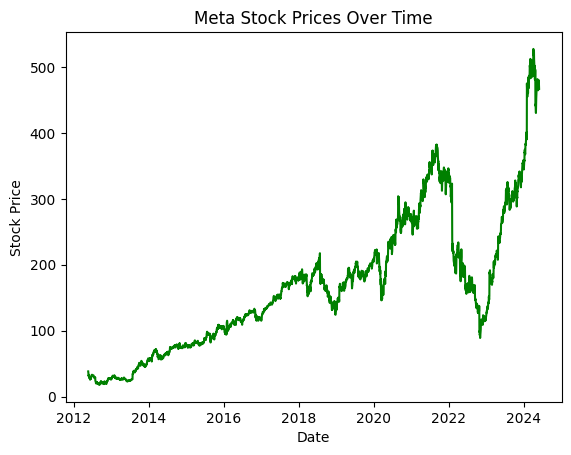

In [12]:
plt.plot(df['ds'], df['y'], label='actual', c='g')
plt.title('Meta Stock Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()

<h1 id='3' style="padding:20px; 
            color:#150d0a;
            margin:10px;
            font-size:220%;
            text-align:center;
            display:fill;
            border-radius:20px;
            border-width: 5px;
            border-style: solid;
            border-color: #150d0a;
            background-color:#82E0AA;
            overflow:hidden;
            font-weight:500">🚂 Train the Model</h1>

<div class="alert alert-block alert-success">
Assign the variable 'model' to the NeuralProphet model that we imported. Fit the model to our dataframe.
</div>

In [13]:
model = NeuralProphet(
    batch_size=16
)

model.fit(df)

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.268% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as B
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 80
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (190) is too small than the required number                     for the learning rate finder (237). The results might not be optimal.


Finding best initial lr:   0%|          | 0/237 [00:00<?, ?it/s]

2024-06-07 20:56:22.412229: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-07 20:56:22.412305: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-07 20:56:22.413939: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Training: 0it [00:00, ?it/s]

,MAE,RMSE,Loss,RegLoss,epoch
0,143.837173,174.416962,0.233778,0.0,0
1,44.556416,59.299454,0.044767,0.0,1
2,35.594986,53.409058,0.040345,0.0,2
3,34.365128,52.860825,0.039105,0.0,3
4,34.156250,52.875751,0.039326,0.0,4
...,...,...,...,...,...
75,29.658445,51.331974,0.037050,0.0,75
76,29.765583,51.201317,0.037018,0.0,76
77,29.787951,51.251007,0.037020,0.0,77
78,29.605373,50.704887,0.036975,0.0,78


<h1 id='4' style="padding:20px; 
            color:#150d0a;
            margin:10px;
            font-size:220%;
            text-align:center;
            display:fill;
            border-radius:20px;
            border-width: 5px;
            border-style: solid;
            border-color: #150d0a;
            background-color:#82E0AA;
            overflow:hidden;
            font-weight:500">📈 Evaluate the Model</h1>

<div class="alert alert-block alert-success">
Assign the variable 'future' to neuralprophet.make_future_dataframe and select the number of periods (in this case period is a day) to predict. 

Then assign the variable 'forecast' to model.predict(future) which creates our prediction for the next X periods.
</div>

In [14]:
future = model.make_future_dataframe(df, periods = 365)

forecast = model.predict(future)
forecast

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.268% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 99.726% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 99.726% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B


Predicting: 190it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,y,yhat1,trend,season_yearly,season_weekly
0,2024-06-03,None,298.413635,239.813766,0.987379,57.612484
1,2024-06-04,None,298.971375,239.840836,0.689888,58.440624
2,2024-06-05,None,298.271942,239.867889,0.404302,57.999725
3,2024-06-06,None,298.329163,239.894958,0.130450,58.303741
4,2024-06-07,None,298.033966,239.922028,-0.125570,58.237511
...,...,...,...,...,...,...
360,2025-10-20,None,309.000671,253.452667,-2.260718,57.808716
361,2025-10-21,None,309.679535,253.479736,-2.265532,58.465321
362,2025-10-22,None,309.327179,253.506805,-2.248264,58.068626
363,2025-10-23,None,309.813843,253.533859,-2.209434,58.489395


 I want to plot out 3 things: 
    
* Actuals - the actual historical performance of Meta stock
* Actual prediction - how the model fits the historical data
* Forecast - the future values that the model has predicted

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.268% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.268% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B


Predicting: 190it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


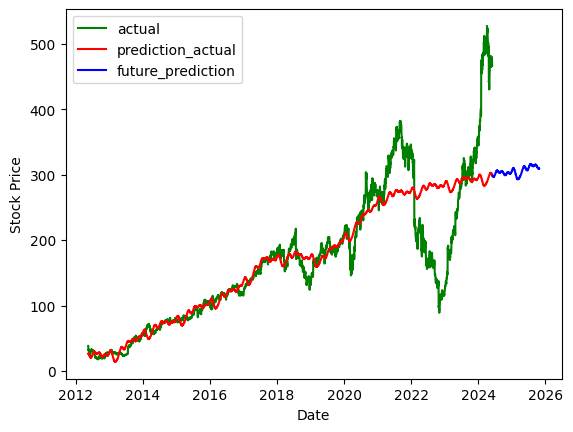

In [15]:
actual_prediction = model.predict(df)

plt.plot(df['ds'], df['y'], label='actual', c='g')
plt.plot(actual_prediction['ds'], actual_prediction['yhat1'], label='prediction_actual', c='r')
plt.plot(forecast['ds'], forecast['yhat1'], label='future_prediction', c='b')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()

plt.show()

Finally, I'll use the plot_components function of neuralprophet to see what our model has observed in terms of trend, yearly seasonality, and weekly seasonality.

In [16]:
model.plot_components(forecast)

ERROR - (NP.plotly.plot_components) - plotly-resampler is not installed. Please install it to use the resampler.


I find this interesting. Our model has made interesting predictions for yearly seasonality, noteably that the stock will dive in early 2025. I'm not sure this is accurate, because META stock *did* dive in 2021-2023, but I'm not certain this is a form of seasonality. I think this reflected a lot of factors that will likely not recurr on any sort of annual basis such as COVID, investment in Meta virtual reality, and the acquisition of several other companies (Instagram etc.)

🎉 **If this notebook helps you out, toss me an upvote** 🎉
